In [73]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from warnings import filterwarnings
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import MinMaxScaler
from sklearn.feature_selection import RFE
from sklearn.metrics import r2_score
import statsmodels.api as sm
from statsmodels.stats.outliers_influence import variance_inflation_factor

In [74]:
#Warning's will not be displayed in the output.
filterwarnings("ignore")

#Set the seed.
seed = 42
np.random.seed(seed)

# Set the test size.
test_set_size = 0.2

## Some dictionaries that are used in the analysis:
binary_dict = {0:"No",1:"Yes"}
seasons_dict = {1:"Spring", 2:"Summer", 3:"Fall", 4:"Winter"}

year_dict = {0:"2018",1:"2019"}

month_dict = month = {1:'Jan',
		2:'Feb',
		3:'Mar',
		4:'Apr',
		5:'May',
		6:'Jun',
		7:'July',
		8:'Aug',
		9:'Sep',
		10:'Oct',
		11:'Nov',
		12:'Dec'}

day_dict = {6:"Mon", 0:"Tues", 1:"Wed", 2:"Thurs", 3:"Fri", 4:"Sat", 5:"Sun"}

weather_dict = {1:"Clear",2:"Mist",3:"Light Snow", 4:"Heavy Snow"}

In [75]:
## Custom Functions:

#Function to build a model using statsmodel api.
def build_model(cols):
    X_train_sm = sm.add_constant(X_train[cols])
    lm = sm.OLS(y_train, X_train_sm).fit()
    print(lm.summary())
    return lm

#Function to calculate VIFs and print them -Takes the columns for which VIF to be calcualted as a parameter
def get_vif(cols):
    df1 = X_train[cols]
    vif = pd.DataFrame()
    vif['Features'] = df1.columns
    vif['VIF'] = [variance_inflation_factor(df1.values, i) for i in range(df1.shape[1])]
    vif['VIF'] = round(vif['VIF'],2)
    print(vif.sort_values(by='VIF',ascending=False))

In [76]:
master  = pd.read_csv("day.csv")
master = master.drop(["instant"],axis=1)
master.head()

,dteday,season,yr,mnth,holiday,weekday,workingday,weathersit,temp,atemp,hum,windspeed,casual,registered,cnt
0,01-01-2018,1,0,1,0,6,0,2,14.110847,18.18125,80.5833,10.749882,331,654,985
1,02-01-2018,1,0,1,0,0,0,2,14.902598,17.68695,69.6087,16.652113,131,670,801
2,03-01-2018,1,0,1,0,1,1,1,8.050924,9.47025,43.7273,16.636703,120,1229,1349
3,04-01-2018,1,0,1,0,2,1,1,8.200000,10.60610,59.0435,10.739832,108,1454,1562
4,05-01-2018,1,0,1,0,3,1,1,9.305237,11.46350,43.6957,12.522300,82,1518,1600


### Missing Value Treatment:

In [77]:
print(master.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 730 entries, 0 to 729
Data columns (total 15 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   dteday      730 non-null    object 
 1   season      730 non-null    int64  
 2   yr          730 non-null    int64  
 3   mnth        730 non-null    int64  
 4   holiday     730 non-null    int64  
 5   weekday     730 non-null    int64  
 6   workingday  730 non-null    int64  
 7   weathersit  730 non-null    int64  
 8   temp        730 non-null    float64
 9   atemp       730 non-null    float64
 10  hum         730 non-null    float64
 11  windspeed   730 non-null    float64
 12  casual      730 non-null    int64  
 13  registered  730 non-null    int64  
 14  cnt         730 non-null    int64  
dtypes: float64(4), int64(10), object(1)
memory usage: 85.7+ KB
None


**Conclusion** : <br>
There are no missing values to be dealth with.

### Data Processing

<h4>Data Dictionary:</h4>

The following data dictionary was provided by the company: <br>

- instant: record index
- dteday : date
- season : season (1:spring, 2:summer, 3:fall, 4:winter)
- yr : year (0: 2018, 1:2019)
- mnth : month ( 1 to 12)
- holiday : weather day is a holiday or not (extracted from http://dchr.dc.gov/page/holiday-schedule)
- weekday : day of the week
- workingday : if day is neither weekend nor holiday is 1, otherwise is 0.
+ weathersit : 
	- 1: Clear, Few clouds, Partly cloudy, Partly cloudy
	- 2: Mist + Cloudy, Mist + Broken clouds, Mist + Few clouds, Mist
	- 3: Light Snow, Light Rain + Thunderstorm + Scattered clouds, Light Rain + Scattered clouds
	- 4: Heavy Rain + Ice Pallets + Thunderstorm + Mist, Snow + Fog
- temp : temperature in Celsius
- atemp: feeling temperature in Celsius
- hum: humidity
- windspeed: wind speed
- casual: count of casual users
- registered: count of registered users
- cnt: count of total rental bikes including both casual and registered

For EDA purposes we need to create and change a few columns:
- Few columns have been changed to *Category* datatype.
- The values from the data dictionary has been replaced with easily readable labels.

In [78]:
# Make a copy of the dataframe for EDA purposes.
data = pd.DataFrame.copy(master)

#dtday: Covert to datetime object.
data["dteday"] = pd.to_datetime(data["dteday"])

#Convert to category dtype:
category_vars = ["weekday","mnth","season","weathersit","holiday","workingday"]
for var in category_vars:
    data[var] = data[var].astype("category")

# Seasons: 
data["season"]  = data["season"].replace(seasons_dict)

#year
data["yr"] = data["yr"].replace({0:"2018",1:"2019"})

#Month:
data["mnth"] = data["mnth"].replace(month_dict)

#weekday
data["weekday"] = data["weekday"].replace(day_dict)

#WorkingDay
data['workingday'] = data["workingday"].replace({0:"No",1:"Yes"})

#Weather Situation
data['weathersit'] = data["weathersit"].replace(weather_dict)

#drop the dteday column as it is unnecessary:
data.drop("dteday",axis=1,inplace=True)
data.head()

,season,yr,mnth,holiday,weekday,workingday,weathersit,temp,atemp,hum,windspeed,casual,registered,cnt
0,Spring,2018,Jan,0,Mon,No,Mist,14.110847,18.18125,80.5833,10.749882,331,654,985
1,Spring,2018,Jan,0,Tues,No,Mist,14.902598,17.68695,69.6087,16.652113,131,670,801
2,Spring,2018,Jan,0,Wed,Yes,Clear,8.050924,9.47025,43.7273,16.636703,120,1229,1349
3,Spring,2018,Jan,0,Thurs,Yes,Clear,8.200000,10.60610,59.0435,10.739832,108,1454,1562
4,Spring,2018,Jan,0,Fri,Yes,Clear,9.305237,11.46350,43.6957,12.522300,82,1518,1600


### Outliers Analysis:

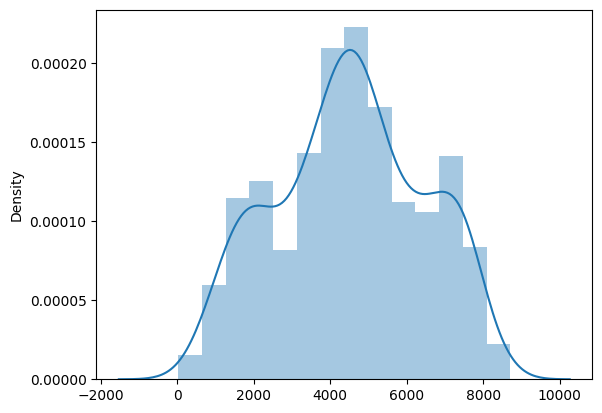

In [79]:
sns.distplot(x=data["cnt"]);

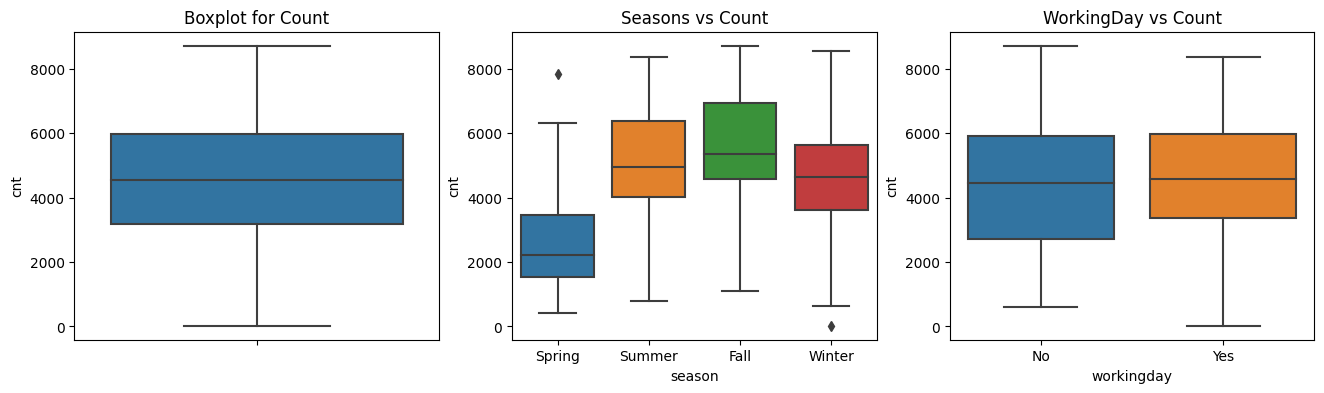

In [80]:
fig, ax = plt.subplots(1,3, figsize=(16,4))

sns.boxplot(data=data,y="cnt",ax=ax[0])
ax[0].set_title("Boxplot for Count")

sns.boxplot(data=data,y="cnt",x="season",ax=ax[1])
ax[1].set_title("Seasons vs Count")

sns.boxplot(data=data,y="cnt",x="workingday",ax=ax[2])
ax[2].set_title("WorkingDay vs Count")

plt.show()

*Conclusion* :<br>
- Spring season has lower usage count for bikes.
- The medians for Working Day or Non-Working is similar.

### Correlation Analysis:

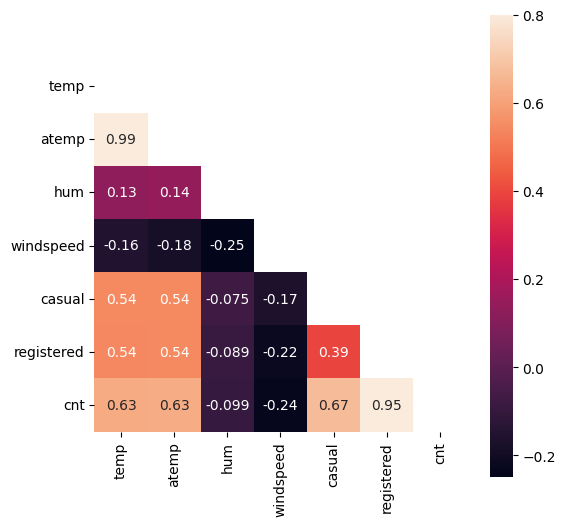

In [81]:
corr = data[["temp","atemp","hum","windspeed","casual","registered","cnt"]].corr()

mask = np.zeros_like(corr, dtype=np.bool)
mask[np.triu_indices_from(mask)] = True
plt.figure(figsize=(6,6))
sns.heatmap(corr, annot=True,mask=mask,square=True,vmax=0.8);

**Conclusion** : <br>
- *casual* and  *registered* are highly correlated to *cnt* (the target variable), thus they can be dropped.
- *temp* and *atemp* are also highly correlated, thus either one can be dropped for modelling.

<h3> Anaylsis of Count <h4>

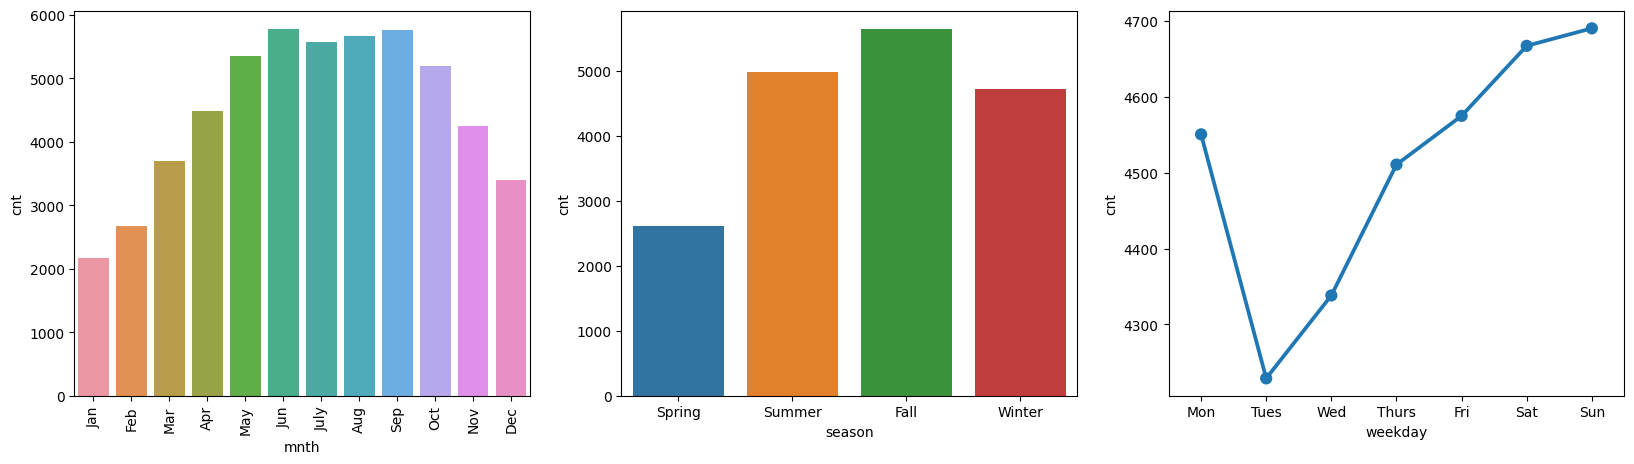

In [82]:
fig,ax = plt.subplots(1,3,figsize=(20,5))

monthAggregated = pd.DataFrame(data.groupby("mnth")["cnt"].mean()).reset_index()
monthSorted = monthAggregated.sort_values(by="cnt",ascending=False)
# plt.xticks(rotation=90)
# plt.title("Count vs Month")
ax[0].set_xticklabels(ax[0].get_xticks(), rotation = 90)
sns.barplot(data=monthSorted,x="mnth",y="cnt",ax=ax[0]);


seasonAggregated = pd.DataFrame(data.groupby("season")["cnt"].mean()).reset_index()
seasonSorted = seasonAggregated.sort_values(by="cnt",ascending=False)
# plt.xticks(rotation=90)
# plt.title("Count vs Seasons")
sns.barplot(data=seasonSorted,x="season",y="cnt",ax=ax[1]);

weekdayAggregated = pd.DataFrame(data.groupby("weekday")["cnt"].mean()).reset_index()
weekdaySorted = weekdayAggregated.sort_values(by="cnt",ascending=False)
# plt.xticks(rotation=90)
# plt.title("Count vs Day of the Week")
sns.pointplot(data=weekdaySorted,x="weekday",y="cnt",ax=ax[2],order=list(day_dict.values()));

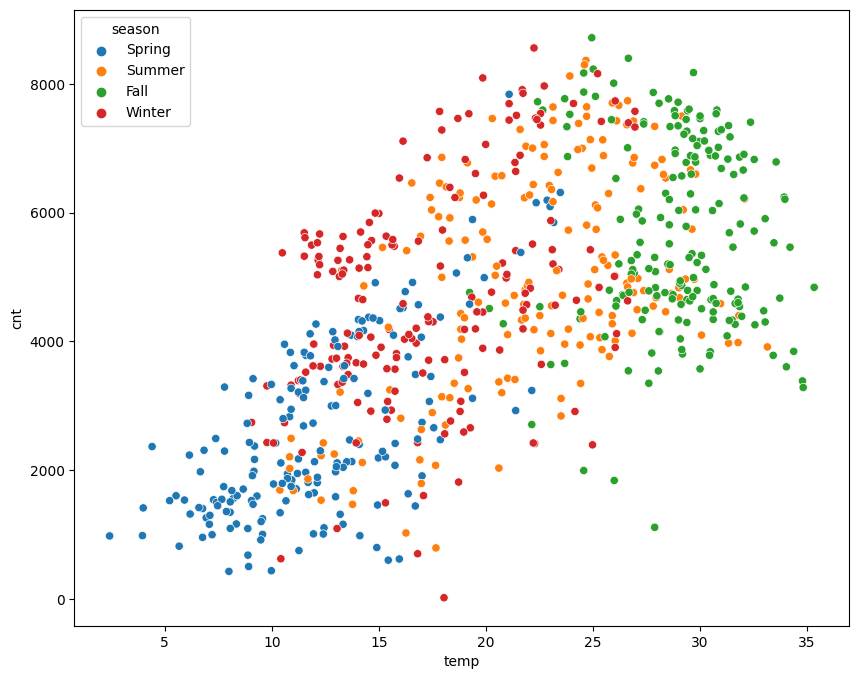

In [83]:
# Temperature vs Count
plt.figure(figsize=(10,8))
sns.scatterplot(x=data["temp"],y=data["cnt"],hue=data["season"]);

**Conclusion** : <br>
- The months of May to September sees the highest demand of bikes. 
- This corresponds to pleasure temperature range of 20&deg;C to 30&deg;C
- Saturday and Sunday sees the highest demand per week. This kind of goes against logic that weekdays would see more demand due to work/school hours.
- It is surprisingly odd that Tuesday sees the lowest number of demand, irrespective of the similar count of values in the dataset. 

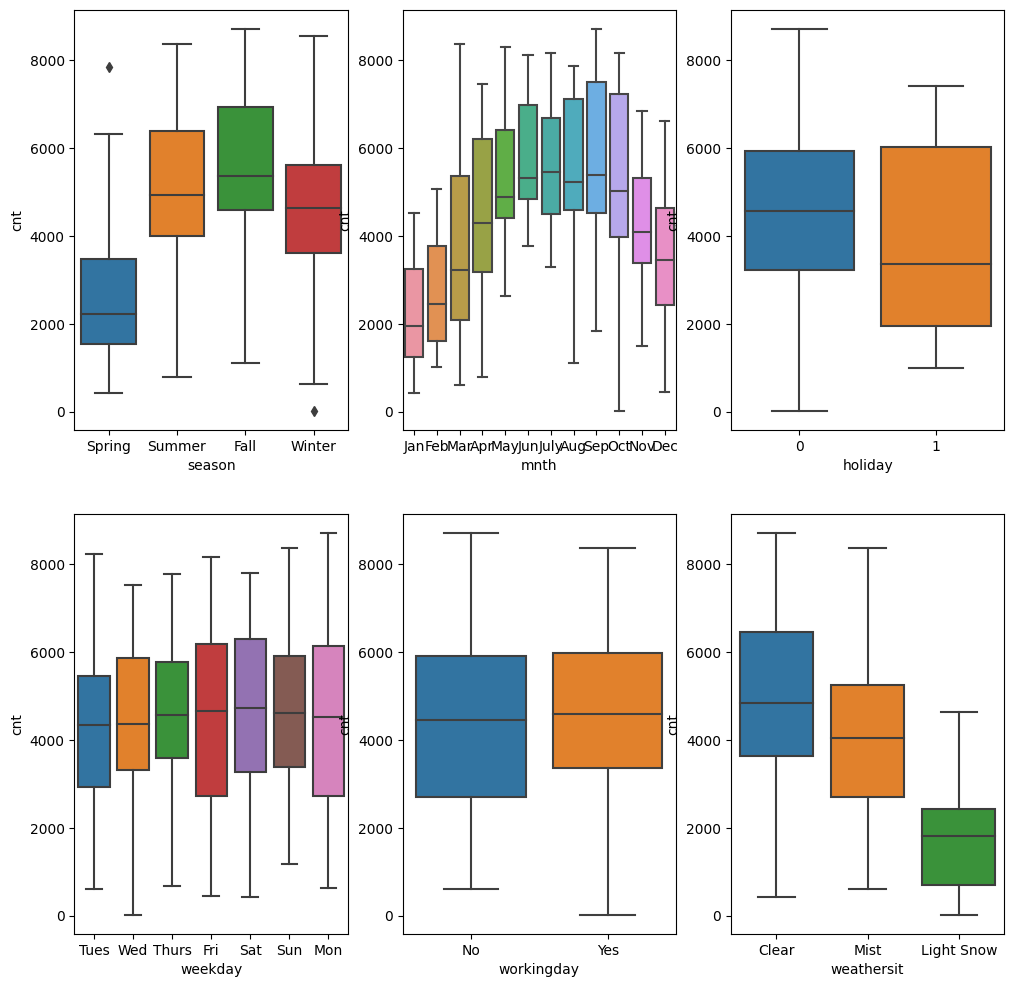

In [84]:
# Boxplots to check Target variable (Count) against other categorical predictors:
categorical_vars = ['season','mnth','holiday','weekday','workingday','weathersit']
plt.figure(figsize=(12, 12))
for i in enumerate(categorical_vars):
    plt.subplot(2,3,i[0]+1)
    sns.boxplot(data=data, x=i[1], y='cnt')
plt.show()

---

## Data Modelling

#### Data Preparation:

We will begin the modelling processby dropping the unnecessary columns from the main dataset:

| Column | Reason |
| ----------- | ----------- |
| dteday | Unnecessary as we have built the new features from it |
| Temp | Highly correlated to 'atemp' (temperature that user feels). <br>Keeping 'atemp' is logical as user will decide if they want to get a bike or not<br>based on what temperature they feel |
|Casual and Registered| These columns are highly correlated to the *cnt* as *cnt* is total sum of these two columns.|

In [85]:
master = master.drop(["dteday","temp","casual","registered"],axis=1)
master.head()

,season,yr,mnth,holiday,weekday,workingday,weathersit,atemp,hum,windspeed,cnt
0,1,0,1,0,6,0,2,18.18125,80.5833,10.749882,985
1,1,0,1,0,0,0,2,17.68695,69.6087,16.652113,801
2,1,0,1,0,1,1,1,9.47025,43.7273,16.636703,1349
3,1,0,1,0,2,1,1,10.60610,59.0435,10.739832,1562
4,1,0,1,0,3,1,1,11.46350,43.6957,12.522300,1600


In [86]:
#Convert to category dtype:
category_vars = ["weekday","mnth","season","weathersit","holiday","workingday"]
for var in category_vars:
    master[var] = master[var].astype("category")

# Seasons: 
master["season"]  = master["season"].replace(seasons_dict)

# Year:
master["yr"]  = master["yr"].replace(year_dict)

#Month:
master["mnth"] = master["mnth"].replace(month_dict)

#weekday
master["weekday"] = master["weekday"].replace(day_dict)

#Weather Situation
master['weathersit'] = master["weathersit"].replace(weather_dict)

#WorkingDay and holiday
master['workingday'] = master["workingday"].replace(binary_dict)
master['holiday'] = master["holiday"].replace(binary_dict)

master.head()

,season,yr,mnth,holiday,weekday,workingday,weathersit,atemp,hum,windspeed,cnt
0,Spring,2018,Jan,No,Mon,No,Mist,18.18125,80.5833,10.749882,985
1,Spring,2018,Jan,No,Tues,No,Mist,17.68695,69.6087,16.652113,801
2,Spring,2018,Jan,No,Wed,Yes,Clear,9.47025,43.7273,16.636703,1349
3,Spring,2018,Jan,No,Thurs,Yes,Clear,10.60610,59.0435,10.739832,1562
4,Spring,2018,Jan,No,Fri,Yes,Clear,11.46350,43.6957,12.522300,1600


Convert to dummy variables using One-Hot Encoding:

In [87]:
cat_vars = ["season","yr","mnth","holiday","weekday","workingday"]
df = pd.get_dummies(master,columns=cat_vars,drop_first=True)
df = pd.get_dummies(df,columns=["weathersit"])
print(df.columns)
df.head()

Index(['atemp', 'hum', 'windspeed', 'cnt', 'season_Summer', 'season_Fall',
       'season_Winter', 'yr_2019', 'mnth_Feb', 'mnth_Mar', 'mnth_Apr',
       'mnth_May', 'mnth_Jun', 'mnth_July', 'mnth_Aug', 'mnth_Sep', 'mnth_Oct',
       'mnth_Nov', 'mnth_Dec', 'holiday_Yes', 'weekday_Wed', 'weekday_Thurs',
       'weekday_Fri', 'weekday_Sat', 'weekday_Sun', 'weekday_Mon',
       'workingday_Yes', 'weathersit_Clear', 'weathersit_Mist',
       'weathersit_Light Snow'],
      dtype='object')


,atemp,hum,windspeed,cnt,season_Summer,season_Fall,season_Winter,yr_2019,mnth_Feb,mnth_Mar,...,weekday_Wed,weekday_Thurs,weekday_Fri,weekday_Sat,weekday_Sun,weekday_Mon,workingday_Yes,weathersit_Clear,weathersit_Mist,weathersit_Light Snow
0,18.18125,80.5833,10.749882,985,0,0,0,0,0,0,...,0,0,0,0,0,1,0,0,1,0
1,17.68695,69.6087,16.652113,801,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,1,0
2,9.47025,43.7273,16.636703,1349,0,0,0,0,0,0,...,1,0,0,0,0,0,1,1,0,0
3,10.60610,59.0435,10.739832,1562,0,0,0,0,0,0,...,0,1,0,0,0,0,1,1,0,0
4,11.46350,43.6957,12.522300,1600,0,0,0,0,0,0,...,0,0,1,0,0,0,1,1,0,0


#### Splitting Data into training and test set:

In [88]:
y = df.pop("cnt")
X = df

In [89]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=test_set_size, random_state=seed)

In [90]:
print(X_train.shape)
print(X_test.shape)

(584, 29)
(146, 29)


#### Scaling the continuous variables: <br>
Scaling is done so that all the *numerical* features (which are likely to have different magnitude and units) have the same scale so as to get the correct model.

In [91]:
num_vars = ["atemp","hum","windspeed"]
scaler = MinMaxScaler()
X_train[num_vars] = scaler.fit_transform(X_train[num_vars])

Checking the correlation of all the features that have been generated: <br>

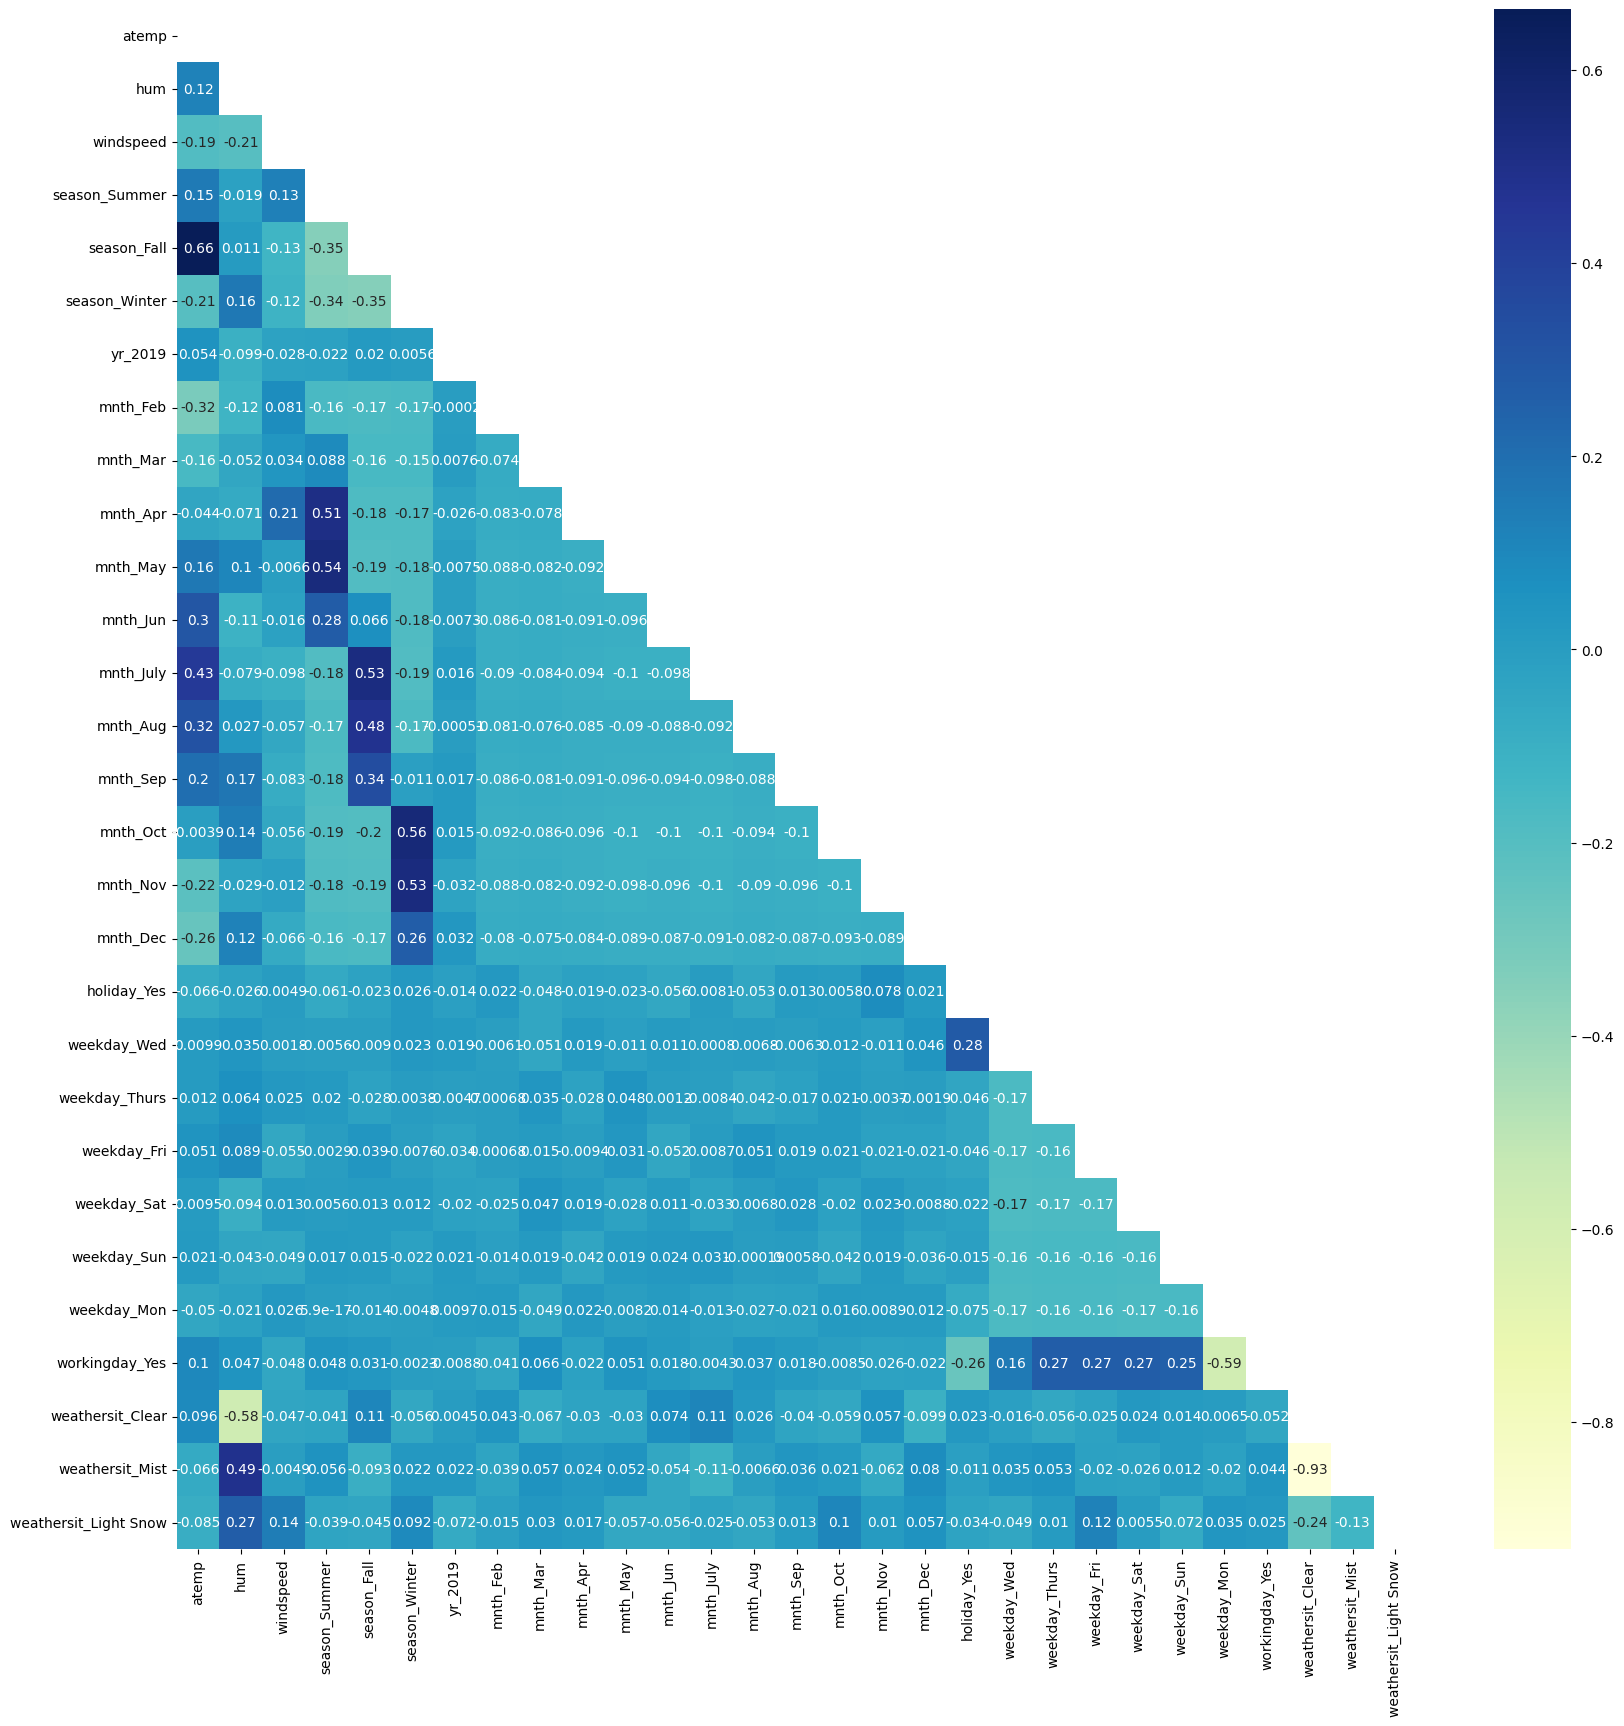

In [92]:
plt.figure(figsize=(20,20))

corr = X_train.corr()
mask = np.zeros_like(corr, dtype=np.bool)
mask[np.triu_indices_from(mask)] = True
sns.heatmap(corr, annot = True, cmap="YlGnBu",mask=mask)
plt.show()

#### Feature Selection

For selecting the appropriate features for the model, we will be using Recursive Feature Elimination(*RFE*) method.

In [93]:
# First Model
lr = LinearRegression()
lr.fit(X_train,y_train)

LinearRegression()

Right now we have 30 features. Using RFE, let's cut down to top 20.

In [94]:
rfe = RFE(estimator=lr,n_features_to_select=20)
rfe.fit(X=X_train,y=y_train)
list(zip(X_train.columns,rfe.support_, rfe.ranking_))

[('atemp', True, 1),
 ('hum', True, 1),
 ('windspeed', True, 1),
 ('season_Summer', True, 1),
 ('season_Fall', True, 1),
 ('season_Winter', True, 1),
 ('yr_2019', True, 1),
 ('mnth_Feb', False, 6),
 ('mnth_Mar', True, 1),
 ('mnth_Apr', False, 4),
 ('mnth_May', True, 1),
 ('mnth_Jun', False, 3),
 ('mnth_July', True, 1),
 ('mnth_Aug', False, 5),
 ('mnth_Sep', True, 1),
 ('mnth_Oct', True, 1),
 ('mnth_Nov', True, 1),
 ('mnth_Dec', True, 1),
 ('holiday_Yes', True, 1),
 ('weekday_Wed', False, 2),
 ('weekday_Thurs', False, 10),
 ('weekday_Fri', False, 7),
 ('weekday_Sat', False, 9),
 ('weekday_Sun', False, 8),
 ('weekday_Mon', True, 1),
 ('workingday_Yes', True, 1),
 ('weathersit_Clear', True, 1),
 ('weathersit_Mist', True, 1),
 ('weathersit_Light Snow', True, 1)]

Now we have the features along with their imporatance to the target variable.

#### Manual Elimination of Features using statsmodel

In [97]:
# Features selected by RFE:
X_train.columns[rfe.support_]

Index(['atemp', 'hum', 'windspeed', 'season_Summer', 'season_Fall',
       'season_Winter', 'yr_2019', 'mnth_Mar', 'mnth_May', 'mnth_July',
       'mnth_Sep', 'mnth_Oct', 'mnth_Nov', 'mnth_Dec', 'holiday_Yes',
       'weekday_Mon', 'workingday_Yes', 'weathersit_Clear', 'weathersit_Mist',
       'weathersit_Light Snow'],
      dtype='object')

In [98]:
# Features not selected by RFE:
X_train.columns[~rfe.support_]

Index(['mnth_Feb', 'mnth_Apr', 'mnth_Jun', 'mnth_Aug', 'weekday_Wed',
       'weekday_Thurs', 'weekday_Fri', 'weekday_Sat', 'weekday_Sun'],
      dtype='object')

# Building Model:
Building the model based on the features selected by the RFE.

Model 1: <br>
All the features selected by RFE.

In [102]:
cols  = ['atemp', 'hum', 'windspeed', 'season_Summer', 'season_Fall',
       'season_Winter', 'yr_2019', 'mnth_Mar', 'mnth_May', 'mnth_July',
       'mnth_Sep', 'mnth_Oct', 'mnth_Nov', 'mnth_Dec', 'holiday_Yes',
       'weekday_Mon', 'workingday_Yes', 'weathersit_Clear', 'weathersit_Mist',
       'weathersit_Light Snow']
build_model(cols)
get_vif(cols)

                            OLS Regression Results                            
Dep. Variable:                    cnt   R-squared:                       0.842
Model:                            OLS   Adj. R-squared:                  0.837
Method:                 Least Squares   F-statistic:                     158.1
Date:                Sun, 09 Oct 2022   Prob (F-statistic):          1.80e-211
Time:                        22:14:55   Log-Likelihood:                -4715.2
No. Observations:                 584   AIC:                             9470.
Df Residuals:                     564   BIC:                             9558.
Df Model:                          19                                         
Covariance Type:            nonrobust                                         
                            coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------------------------------------------------------
const                   688.01